### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)
#pd.reset_option("all")

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
35 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 42 flags
Removed 42 flags from df
df sorted by tus
2020-12-27 15:14:06.853667
first tus:  -469628.27777777775 | max tus:  1539352.3055555555
5611
tus array OK ...


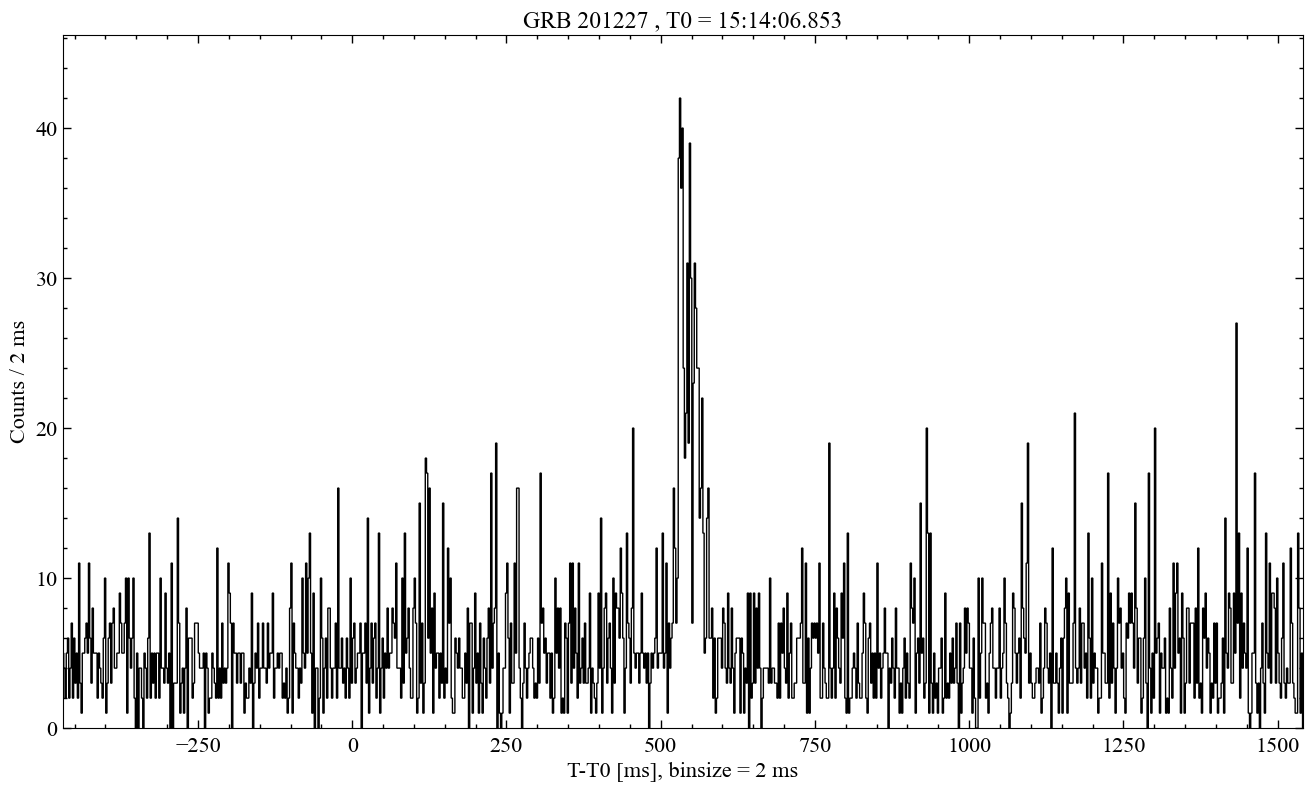

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB201227",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

0.512


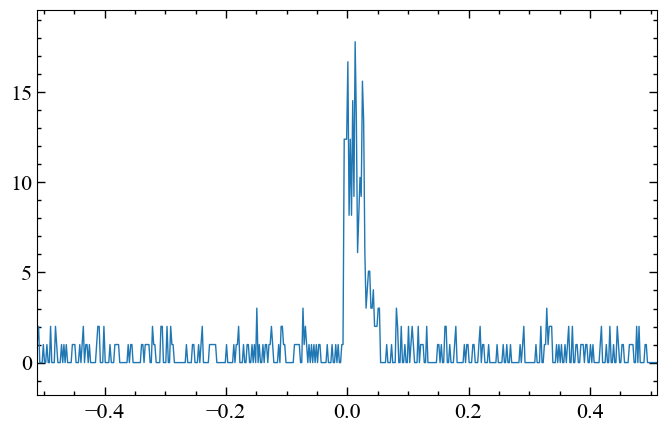

In [4]:
kw_filename = "GRB201227A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
ToF = 0.7142


kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

In [7]:
kw_lc.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 201227A KW 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/KW_originalLC.png")

# CrossCorr
    TODO:
        -Make a function for finding the optimal tlagg
        -run the laggs array containing all of the possible tlaggs.
        -Time range (+- T s) selected from peak count rate pr bin

### ASIM prep

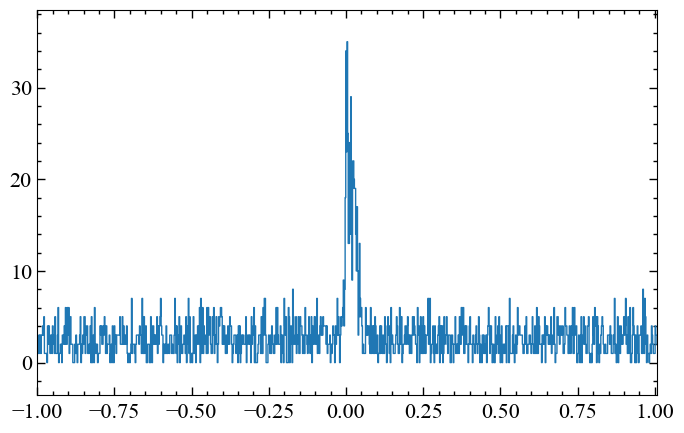

In [47]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 360<=kev<=1360:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]

laggApprox = -0.531   
tus += laggApprox
#asim_binsOrg = np.round(np.arange(-1.5,2,binsize,dtype=np.float32),3)
asim_binsOrg = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]

#iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.05)
#iAsimBkgEnd = find_nearest(asimEdges,0-)
#asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
"""
asimBkg = 2.5146341463414634
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg
"""

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.show()


df = pd.DataFrame(data={"Ti":np.round(asimEdges[:-1],3), "Tf":np.round(asimEdges[1:],3), "Counts":np.round(asimCounts,2)})
np.savetxt(fname="asimLC_tshift_-0.531s",X=df,fmt=["%.3f","%.3f","%.2f"],header="Ti,Tf,Counts",delimiter=",")
#asimLC = LC(time=np.round(asimEdges[:-1],3)+binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)

### New ASIM prep

In [ ]:
binsize in np.arange(0.001,0.05,0.001):
binsize=np.round(binsize,3)
#binsize = 0.05 #50ms for LC and CC. Should be lower as the CC takes place
asimTus = asimDF["tus"].to_numpy()/1e6
iMax = find_nearest(asimTus,8)
asimTus = asimTus[:iMax]
bins = np.arange(asimTus[0],asimTus[-1]+binsize,binsize)

asimHist = np.histogram(asimTus,bins=bins)
asimCounts,asimEdges = asimHist[0], asimHist[1]
#plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
#plt.show()
iAsimBkgEnd = find_nearest(asimEdges,0)
asimBkg = sum(asimCounts[:iAsimBkgEnd])/len(asimCounts[:iAsimBkgEnd])

for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg
#plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
#plt.show()

In [27]:
asimLC.plot(labels=["T-T0 [s] ASIM ref. frame","counts/2ms"],title="GRB 201227A, ASIM 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/ASIM_originalLC.png")

### LC approx compare and tlagg

In [28]:
kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asim_lc=asimLC,binsize=binsize)
#CompareLC actually cuts correctly kw if asim LC is "short"
CC = CrossCorrelation(kwCompare,asimCompare,mode="full")
CClagg=CC.time_shift
tlagg = laggApprox + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
kwFinal,asimFinal = CompareLC(kw_lc=kw_lc,asim_lc=asimLC.shift(CClagg),binsize=binsize,okReturn=True)

Total lagg (s):  -0.530859375 | CC lagg:  -0.130859375


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


### Approx shift

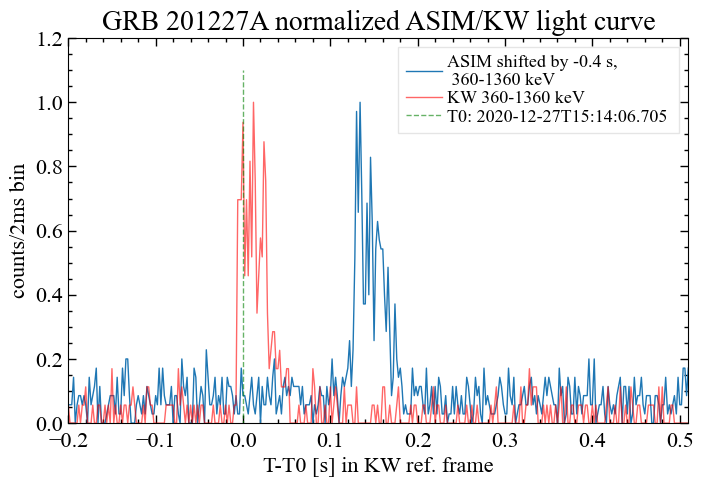

In [95]:
T0_approx = T0_ASIM+timedelta(seconds=laggApprox)
T0_KW = datetime.strptime("2020-12-27 15:14:06.705","%Y-%m-%d %H:%M:%S.%f")

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare),label="ASIM shifted by {} s, \n 360-1360 keV".format(laggApprox))
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare),c="r",alpha=0.6,label="KW 360-1360 keV")

plt.title("GRB 201227A normalized ASIM/KW light curve")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {} ".format(T0_KW.isoformat(timespec='milliseconds')),alpha=0.6,linestyle="--")
plt.legend()
plt.ylim(bottom=0,top=1.2)
plt.xlim(left=-0.2,right=max(kwCompare.bin_lo))
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/ASIM_KW_AppShift.png")
plt.show()

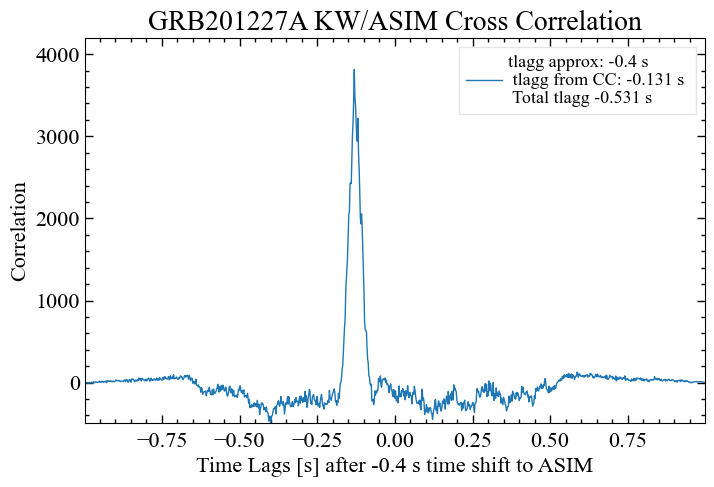

In [96]:
plt.plot(CC.time_lags,CC.corr,label="tlagg approx: {} s \n tlagg from CC: {} s \n Total tlagg {} s".format(np.round(laggApprox,3), np.round(CClagg,3), np.round(tlagg,3)))
plt.title("GRB201227A KW/ASIM Cross Correlation")
plt.xlabel('Time Lags [s] after {} s time shift to ASIM'.format(laggApprox))
plt.ylabel('Correlation')
plt.legend()
plt.ylim(bottom=min(CC.corr),top=max(CC.corr)+max(CC.corr)/1e1)
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/CC_asim_kw.png")
plt.show()

### Final LC

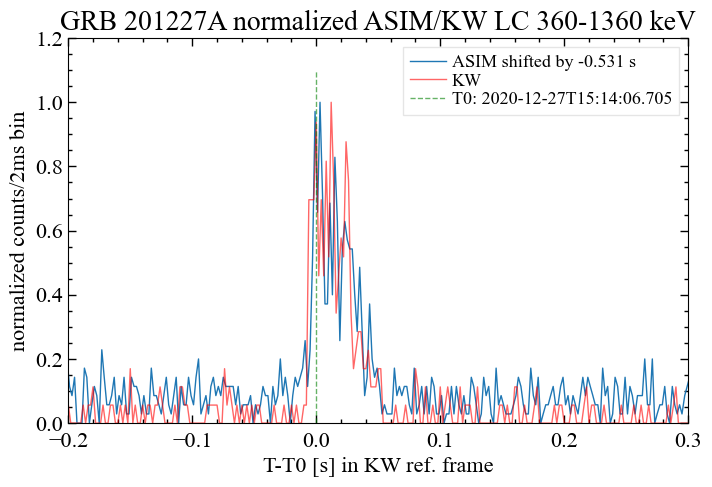

In [100]:
T0_final = T0_ASIM+timedelta(seconds=tlagg)

i_asimStart = find_nearest(asimFinal.bin_lo,kwCompare.bin_lo[0])
i_kwEnd = find_nearest(kwCompare.bin_lo,asimFinal.bin_lo[-1])

plt.plot(np.round(asimFinal.bin_lo[i_asimStart:],3),asimFinal.counts[i_asimStart:]/max(asimFinal.counts),label="ASIM shifted by {} s".format(np.round(tlagg,3)))
plt.plot(np.round(kwCompare.bin_lo[:i_kwEnd],3),kwCompare.counts[:i_kwEnd]/max(kwCompare.counts),c="r",alpha=0.6,label="KW")

plt.title("GRB 201227A normalized ASIM/KW LC 360-1360 keV")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
plt.xlim(left=-0.2,right=0.3)
plt.ylim(bottom=0,top=1.2)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/overlappingLC_asim_kw.png")
plt.show()

### Time difference (ToF & tlaggg)

In [101]:
T0_ASIMfinal = T0_ASIM + timedelta(seconds=-ToF-tlagg)
diff = T0_ASIMfinal-T0_KW

print(T0_ASIM+timedelta(seconds=-ToF-tlagg))
print("Good to get the T0-KW after applying ToF and tlagg to T0_ASIM")
print("Still {} s difference".format(diff.total_seconds()))

2020-12-27 15:14:06.670326
Good to get the T0-KW after applying ToF and tlagg to T0_ASIM
Still -0.034674 s difference


# Extracting ASIM data

In [2]:
ASIM_df,T0 = complete_df(grb_id="GRB201227",remove_flag=True)
tlagg = -0.531
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
35 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 42 flags
Removed 42 flags from df
df sorted by tus


In [3]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)

tus array OK ...


In [4]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
keV_df
#All triggers in the time_interval are kept

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  563
n triggers are within bounds  563
keV bins are set for HED
Energies binned!


,bins_keV,counts,poisson_error_counts,duration_seconds
0,10.00000,-9999.0,-9999.000000,-9999.000
1,12.58925,0.0,0.000000,0.064
2,15.84893,0.0,0.000000,0.064
3,19.95262,0.0,0.000000,0.064
4,25.11886,0.0,0.000000,0.064
5,31.62278,0.0,0.000000,0.064
6,39.81072,0.0,0.000000,0.064
7,50.11872,0.0,0.000000,0.064
8,63.09573,0.0,0.000000,0.064
9,79.43282,0.0,0.000000,0.064


In [27]:
bin_lo = keV_df["bins_keV"].to_numpy(dtype=np.float32)
bin_lo[1:]

array([1.258925e+01, 1.584893e+01, 1.995262e+01, 2.511886e+01,
       3.162278e+01, 3.981072e+01, 5.011872e+01, 6.309573e+01,
       7.943282e+01, 1.000000e+02, 1.258925e+02, 1.584893e+02,
       1.995262e+02, 2.511886e+02, 3.162278e+02, 3.981072e+02,
       5.011872e+02, 6.309573e+02, 7.943282e+02, 1.000000e+03,
       1.258925e+03, 1.584893e+03, 1.995262e+03, 2.511886e+03,
       3.162278e+03, 3.981072e+03, 5.011872e+03, 6.309573e+03,
       7.943282e+03, 1.000000e+04, 1.258925e+04, 1.584893e+04,
       1.995262e+04, 2.511886e+04, 3.162278e+04, 3.981072e+04,
       5.011872e+04, 6.309573e+04, 7.943282e+04, 1.000000e+05],
      dtype=float32)

In [11]:
poisson = keV_df["poisson_error_counts"].to_numpy(dtype=np.float32)
poisson[0]= 0
poisson

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  1.       ,
        4.7958317,  5.91608  , 10.488089 ,  9.539392 ,  8.717798 ,
        7.483315 ,  7.28011  ,  5.91608  ,  4.1231055,  3.7416575,
        3.       ,  3.       ,  1.7320508,  2.236068 ,  1.7320508,
        0.       ,  2.       ,  2.       ,  1.4142135,  1.       ,
        3.       ,  1.7320508,  0.       ,  0.       ,  0.       ,
        0.       ], dtype=float32)

In [ ]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

### bakground extraction 

keV_bg = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.3),
                 keV_interval="max",
                 duration=0.6,
                 )

In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')